Simple AB Testing

In [30]:
import pymc3 as pm
from scipy.stats import bernoulli
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [48]:
# Simulate conversion rates
p_true = .05
N = 1500

values = bernoulli.rvs(p_true, size=N, random_state=42)

In [49]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(values))
print("Does this equal the true frequency? %s" % (np.mean(values) == p_true))

What is the observed frequency in Group A? 0.0492
Does this equal the true frequency? False


In [50]:
with model:
    obs = pm.Bernoulli('obs', p, observed=values)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:08<00:00, 8702.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


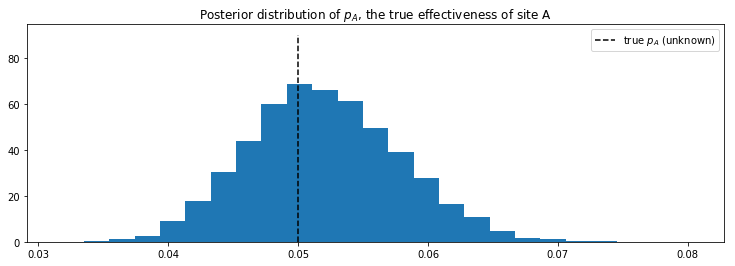

In [41]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

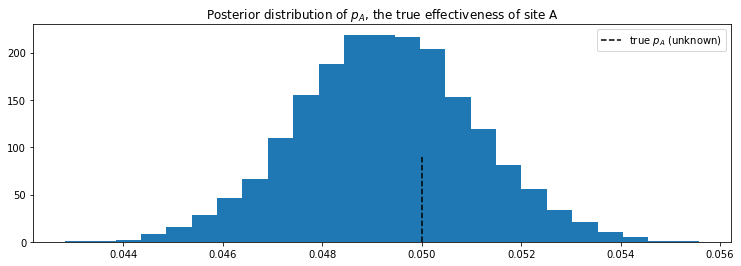

In [51]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

# Simulate conversion rates
p_true = .05
N = 15000

with model:
    obs = pm.Bernoulli('obs', p, observed=values)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]
    
values = bernoulli.rvs(p_true, size=N, random_state=42)
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

Simulate two pages A and B in a AB testing

In [75]:
p_a = .05
p_b = .04

N_a = 1500
N_b = 750 # notice the different N for B!

sim_a = bernoulli.rvs(p_a, size=N_a)
sim_b = bernoulli.rvs(p_b, size=N_b)

print('Observed frequency A: ' + str(np.mean(sim_a)))
print('Observed frequency B: ' + str(np.mean(sim_b)))

with pm.Model() as model:
    
    # priors for our bernoullis
    prior_a = pm.Uniform('prior_a', lower=0, upper=1)
    prior_b = pm.Uniform('prior_b', lower=0, upper=1) 
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", prior_a - prior_b)
    
    # random variables ~ Bernoulli(prior_a)
    simulation_a = pm.Bernoulli('simulation_a', prior_a, observed=sim_a)
    simulation_b = pm.Bernoulli('simulation_b', prior_b, observed=sim_b)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

Observed frequency A: 0.05333333333333334
Observed frequency B: 0.03866666666666667


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [prior_b]
>Metropolis: [prior_a]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:11<00:00, 7105.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [76]:
p_A_samples = burned_trace["prior_a"]
p_B_samples = burned_trace["prior_b"]
delta_samples = burned_trace["delta"]

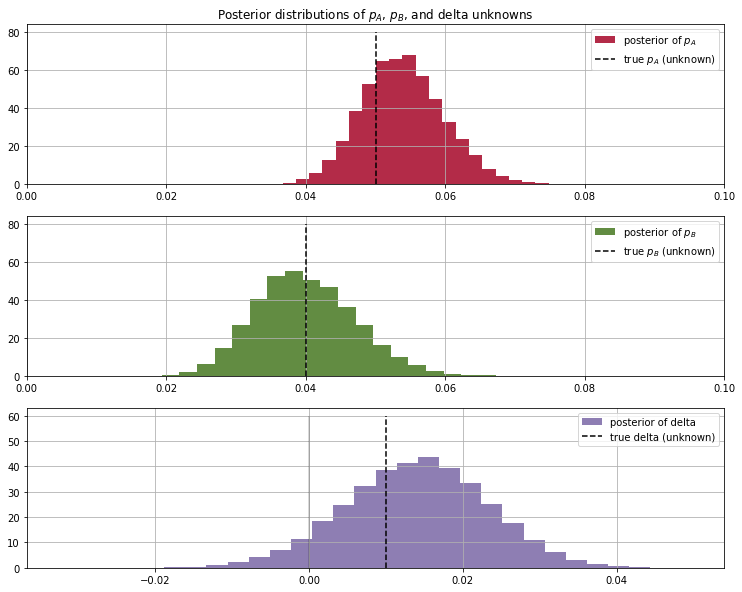

In [77]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(p_a, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")
plt.grid()

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(p_b, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")
plt.grid()

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(p_a - p_b, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right")
plt.grid();

In [79]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.069
Probability site A is BETTER than site B: 0.931
